## **To recreate study results please load package versions found in main_requirements.txt**

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import math
import seaborn as sns
import os

# less common imports
import matplotlib.image as mpimg
from pygam import LinearGAM, GAM, s, l
from sklearn import preprocessing
from scipy import stats
from scipy import spatial
from scipy.stats import f
from sklearn.cluster import AgglomerativeClustering
import shutil
import gc
from seaborn import clustermap
import matplotlib.cm as cm

# %config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2

sc.settings.verbosity = 0
sc.logging.print_header()
sns.set_context("paper")

scanpy==1.6.0 anndata==0.7.4 umap==0.4.3 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.10.1 python-igraph==0.8.0 louvain==0.6.1 leidenalg==0.8.0


In [2]:
# import local module containing misc code, helps keep notebooks clean from commonly used functions
import new_misc_code as nmc 

## **Format logTMM data from limma-voom into workable form for GAM curve fitting**

In [3]:
# Set path and read in logTMM normalized data from limma-voom output directories
# These directories can be downloaded from http://brain.listerlab.org/Major-Traj-Limma-Voom.html
dt_path = "../data/limma-voom/"
dt_fls = os.listdir( path=dt_path)

In [4]:
# read in anndata for obs
adata = sc.read_h5ad( "../data/post-gaba-wt-dev-traj.h5ad")
obs_df = adata.obs.copy()
# clean up dataframe by dropping all duplicates of batch entries
obs_df.drop_duplicates( subset='batch', keep="first", inplace=True)

In [5]:
# select for limma dev-traj directories
###############################
dt_oi = "glimma_dev-traj_"
###############################
oi_fls = [ii for ii in dt_fls if dt_oi in ii]
oi_fls

['glimma_dev-traj_Astro',
 'glimma_dev-traj_ID2',
 'glimma_dev-traj_L2-3_CUX2',
 'glimma_dev-traj_L4_RORB',
 'glimma_dev-traj_L5-6_THEMIS',
 'glimma_dev-traj_L5-6_TLE4',
 'glimma_dev-traj_LAMP5_NOS1',
 'glimma_dev-traj_Micro',
 'glimma_dev-traj_Oligo',
 'glimma_dev-traj_OPC',
 'glimma_dev-traj_Poor-Quality',
 'glimma_dev-traj_PV',
 'glimma_dev-traj_PV_SCUBE3',
 'glimma_dev-traj_SST',
 'glimma_dev-traj_Vas',
 'glimma_dev-traj_VIP']

In [6]:
# 1) read in results files for each and pull sig genes
# 2) read in pseudo-bulk logTMM from limma voom
sig_genes = {}
logTMMs = {}
for fl_itr in oi_fls:
    # clean up file name to use as dict key
    key = fl_itr.replace("glimma_", "")
    key = key.split('-obs')[0]
    key = key.split('dev-traj_')[1]
    # skip poor quality nucs
    if key=='Poor-Quality':
        continue
    # read in results file
    results = pd.read_table( f"{dt_path}{fl_itr}/results_file.txt")
    # find and pull all results columns 
    res_cols = [ii for ii in results.columns if 'Res' in ii]
    res_df = results[res_cols]
    
    # find all genes signifcant for any stage comparison
    sig_mk = np.any( ( res_df!=0).values, axis=1)
    # if no sig genes found skip run
    if( sum(sig_mk)==0):
        print( f"No sig genes found for {key}")
        continue
    # set to dict
    sig_genes[key] = results.index.values[sig_mk]
    
    # read in pseudo-bulk logTMM
    bk_df = pd.read_csv( f"{dt_path}{fl_itr}/logTMM_cts.csv", index_col=[0])
    # clean up columns labels, make them batch
    bk_df.columns = [ii.split('..')[1] for ii in bk_df.columns.values]
    # order columns by age of maturation
    batch_mk = np.in1d( adata.uns['batch_order'], bk_df.columns)
    batch_order_itr = np.array( adata.uns['batch_order'])[batch_mk]
    bk_df = bk_df[batch_order_itr]
    # reduce bulk data to sig genes only
    sig_bk_df = bk_df.loc[sig_genes[key]]
    print(key)
    # set to dict
    logTMMs[key] = sig_bk_df
# sig_genes

Astro
ID2
L2-3_CUX2
L4_RORB
L5-6_THEMIS
L5-6_TLE4
LAMP5_NOS1
Micro
Oligo
OPC
PV
PV_SCUBE3
SST
No sig genes found for Vas
VIP


In [7]:
# save to use in future analysis
nmc.save_obj( logTMMs, f"../data/logTMMs.pkl")

In [8]:
for iii, jjj in sig_genes.items():
    print( iii, jjj.shape)

Astro (3497,)
ID2 (3755,)
L2-3_CUX2 (8842,)
L4_RORB (8885,)
L5-6_THEMIS (6924,)
L5-6_TLE4 (7239,)
LAMP5_NOS1 (2514,)
Micro (58,)
Oligo (2540,)
OPC (1321,)
PV (5558,)
PV_SCUBE3 (2745,)
SST (4377,)
VIP (4624,)


In [9]:
# example logTMM dataframe
logTMMs['Astro'].head()

,RL2103_ga22_v3,RL2107_ga24_v3,RL2121_ga34_v3,RL1777_2d_v3,RL1612_34d_v2,RL2100_86d_v3,RL2104_118d_v3,RL2108_179d_v3,RL2122_301d_v3,RL2125_422d_v3,...,RL2110_10yr_v3,RL2126_10yr_v3,RL2127_12yr_v3,RL2130_14yr_v3,RL2102_16yr_v3,RL2131_17yr_v3,RL2123_20yr_v3,RL2128_20yr_v3,RL2132_25yr_v3,RL2124_40yr_v3
RP4-669L17.10,3.262914,2.563581,5.441405,3.789194,3.777097,4.668260,3.590798,4.147364,5.336433,4.960163,...,5.278157,5.440160,5.193255,5.352841,5.165714,4.598815,5.703545,4.824757,4.666973,5.538194
HES4,8.114207,8.675959,6.533670,8.162519,7.155232,6.822653,7.475238,6.808007,2.653773,3.480646,...,6.554246,3.895045,4.002476,6.637216,6.482754,5.844978,5.066663,5.929921,6.356468,4.827944
B3GALT6,4.381164,3.205800,3.550417,3.986218,4.176051,3.571567,3.496453,3.535681,-0.718015,2.302078,...,3.185246,1.831968,1.884341,2.157840,2.090287,2.927427,1.794633,2.228402,2.401556,1.428959
SCNN1D,2.351506,1.704798,3.896255,2.709747,3.526801,4.354930,2.901563,3.650960,4.545267,3.736044,...,5.563548,4.538673,4.148996,3.750216,5.260352,4.178468,5.579543,4.981960,3.415214,4.111419
MORN1,4.216491,2.981973,4.609465,4.058063,3.990321,4.239048,3.841649,4.133640,3.582350,3.679891,...,4.704451,5.151509,4.472182,4.693571,5.305440,4.545758,4.639772,5.089552,4.363615,5.143683


### Trends on year scale are fit to arcsinh transformed ages using a cofactor which best linearizes the intervals between ages 

In [10]:
from scipy.optimize import fmin
from scipy.stats import pearsonr

# use numpy unique instead of pandas so results are sorted
uq_num_ages = np.unique( adata.obs['numerical_age'])

def f( c, x=uq_num_ages):
    xx = np.arcsinh( x/c)
    yy = np.arange( 0, len( x))
    corr = pearsonr( xx, yy)[0]
    return( 1 - corr)

In [11]:
# rescaling by fitting arcsinh cofactor such that it minimizes anti-correlation
lin_cf = fmin(f,0.40)[0]
adata.uns['arcsinh_cofactor'] = lin_cf
lin_cf

Optimization terminated successfully.
         Current function value: 0.005038
         Iterations: 13
         Function evaluations: 26


0.5549218750000005

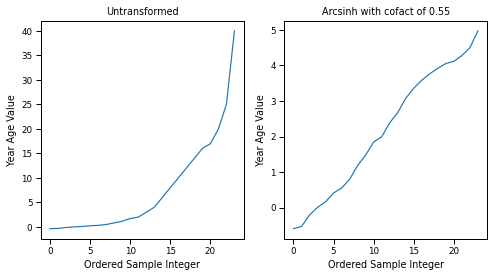

In [12]:
# check if cofactor is nearly linear with evenly placed data pts
fig,[ax0,ax1] = plt.subplots(1,2, figsize=(8,4))
ax0.plot( uq_num_ages)
ax0.set_title('Untransformed')
ax0.set_ylabel('Year Age Value')
ax0.set_xlabel('Ordered Sample Integer')
ax1.plot( np.arcsinh( uq_num_ages/lin_cf))
ax1.set_title(f"Arcsinh with cofact of {round(lin_cf,2)}")
ax1.set_ylabel('Year Age Value')
ax1.set_xlabel('Ordered Sample Integer');

In [13]:
obs_df['arcsin_age'] = np.arcsinh( obs_df['numerical_age'] / lin_cf)

In [14]:
# change column names in each logTMM to arcsinh age of batch
# will use these values as x-axis in curve fitting
plot_labels = {}
for key_itr in logTMMs.keys():
    new_cols = []
    for col_itr in logTMMs[key_itr]:
        age_itr = obs_df.loc[obs_df['batch']==col_itr,'arcsin_age'].values[0]
        new_cols.append( round( age_itr, ndigits=4))
    plot_labels[key_itr] = [ii.split('_')[1] for ii in logTMMs[key_itr].columns]
    logTMMs[key_itr].columns = new_cols

In [15]:
logTMMs['Astro'].head()

,-0.5877,-0.5281,-0.2059,0.0099,0.1671,0.4128,0.5538,0.7967,1.1870,1.4804,...,3.5854,3.5854,3.7675,3.9215,4.0550,4.1156,4.2780,4.2780,4.5011,4.9710
RP4-669L17.10,3.262914,2.563581,5.441405,3.789194,3.777097,4.668260,3.590798,4.147364,5.336433,4.960163,...,5.278157,5.440160,5.193255,5.352841,5.165714,4.598815,5.703545,4.824757,4.666973,5.538194
HES4,8.114207,8.675959,6.533670,8.162519,7.155232,6.822653,7.475238,6.808007,2.653773,3.480646,...,6.554246,3.895045,4.002476,6.637216,6.482754,5.844978,5.066663,5.929921,6.356468,4.827944
B3GALT6,4.381164,3.205800,3.550417,3.986218,4.176051,3.571567,3.496453,3.535681,-0.718015,2.302078,...,3.185246,1.831968,1.884341,2.157840,2.090287,2.927427,1.794633,2.228402,2.401556,1.428959
SCNN1D,2.351506,1.704798,3.896255,2.709747,3.526801,4.354930,2.901563,3.650960,4.545267,3.736044,...,5.563548,4.538673,4.148996,3.750216,5.260352,4.178468,5.579543,4.981960,3.415214,4.111419
MORN1,4.216491,2.981973,4.609465,4.058063,3.990321,4.239048,3.841649,4.133640,3.582350,3.679891,...,4.704451,5.151509,4.472182,4.693571,5.305440,4.545758,4.639772,5.089552,4.363615,5.143683


## **Fit GAM to each gene across stages**

In [16]:
# This will take a while to run
n_splines = 12
n_grid_pts = 100
gam_fits = {}
for key_itr, sig_df in logTMMs.items(): 
    # set x-axis for dev-traj using column values
    ax = sig_df.columns
    # dataframe to hold fits
    fits_df = pd.DataFrame( np.zeros((sig_df.shape[0],n_grid_pts), dtype=float), index=sig_df.index)
    for gene_itr in sig_df.index:
        # y-axis gene values
        ay = sig_df.loc[gene_itr,:].values
        # fit GAM
        gam = LinearGAM( s( 0, lam=0.6, n_splines=n_splines), fit_intercept=False).fit( ax, ay)
        axx = gam.generate_X_grid( term=0, n=n_grid_pts)
        yyy = gam.predict( X=axx)
        fits_df.loc[gene_itr,:] = yyy
        
    gam_fits[key_itr] = fits_df  
    print( key_itr)  

Astro
ID2
L2-3_CUX2
L4_RORB
L5-6_THEMIS
L5-6_TLE4
LAMP5_NOS1
Micro
Oligo
OPC
PV
PV_SCUBE3
SST
VIP


In [17]:
# save to use in future analysis
nmc.save_obj( gam_fits, f"../data/AGE_gam_fits_12_grid{n_grid_pts}.pkl")

## **Plot trend fits**

In [18]:
shape_dict = {}
for ii in adata.uns['major_clust_plot_order']:
    if ii=='Poor-Quality':
        continue
    if ii in ['L2-3_CUX2', 'L4_RORB', 'L5-6_THEMIS','L5-6_TLE4']:
        shape_dict[ii] = 'o'
    elif ii in ['VIP', 'ID2', 'LAMP5_NOS1']:
        shape_dict[ii] = 'v'
    elif ii in ['SST', 'PV', 'PV_SCUBE3']:
        shape_dict[ii] = '^'
    else:
        shape_dict[ii] = 'P'

In [19]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.style.use('seaborn-whitegrid')
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["legend.markerscale"] = 3.5
plt.rc('font', size=14) 

In [20]:
def plot_cluters_gene( clusters, gene, gam_fits=gam_fits, logTMMs=logTMMs, age_order=adata.uns['age_order']):
    # set up plot figure
    plt.figure( figsize=(14,6))
    # plot parameters
    alpha = 0.9
    # list of possible clusters
    gam_clusters = list( gam_fits.keys())
    # loop through clusters
    for clust_itr in clusters:
        # make sure cluster is in dataframe
        if( clust_itr not in gam_clusters):
            print( f"{clust_itr} cluster name not found, the following are valid names:\n {gam_clusters}")
            continue
        
        # gam dataframe of fits for cluster
        gam_df = gam_fits[clust_itr]
        # get x-axis for scatter plot of data points
        scat_cols = logTMMs[clust_itr].columns
        scat_x = (scat_cols+abs(min(scat_cols)))*n_grid_pts/max(scat_cols+abs(min(scat_cols)))
        
        # determine if devDEG or not, then plot trend and scatter
        if gene in gam_df.index:
            # plot trend fit
            trend = gam_df.loc[gene]
            plt.scatter( scat_x, logTMMs[clust_itr].loc[gene].values, c=adata.uns['major_clust_colors_dict'][clust_itr], alpha=0.9, s=25.0, marker=shape_dict[clust_itr], label=clust_itr)
            plt.plot( np.linspace( 0.5, len(trend)-0.5, len(trend)), trend, linewidth=4.0, alpha=alpha, color=adata.uns['major_clust_colors_dict'][clust_itr])
        else:
            continue
            print( f"{gene} not found in {clust_itr} logTMM data")
    
    plt.legend( bbox_to_anchor=(1.10, 0.45), loc="center");
    # add xticks using L2/3 since all samples are present in that traj
    scat_cols = logTMMs['L2-3_CUX2'].columns
    scat_x = (scat_cols+abs(min(scat_cols)))*n_grid_pts/max(scat_cols+abs(min(scat_cols)))
    tick_labs = age_order
    plt.xticks( ticks=scat_x, labels=tick_labs, rotation=90, fontsize=10);
    plt.yticks(fontsize=14)
    plt.title( gene, fontsize=18, style='italic', weight='bold')
    plt.xlim(min(scat_x)-2,max(scat_x)+2)
    plt.ylabel( 'Log2 CPM')
    plt.show();
#     plt.savefig( f"./figs/major-clust-traj__{gene}.svg", format='svg', bbox_inches='tight');
    return

In [21]:
# set lists of clusters to plot
pns = ['L2-3_CUX2', 'L4_RORB', 'L5-6_THEMIS', 'L5-6_TLE4']
neurons = ['L2-3_CUX2', 'L4_RORB', 'L5-6_THEMIS', 'L5-6_TLE4',
           'VIP', 'ID2', 'LAMP5_NOS1', 
           'SST', 'PV', 'PV_SCUBE3']
all_clusts = np.append( neurons, ['Astro', 'OPC', 'Oligo', 'Micro'])

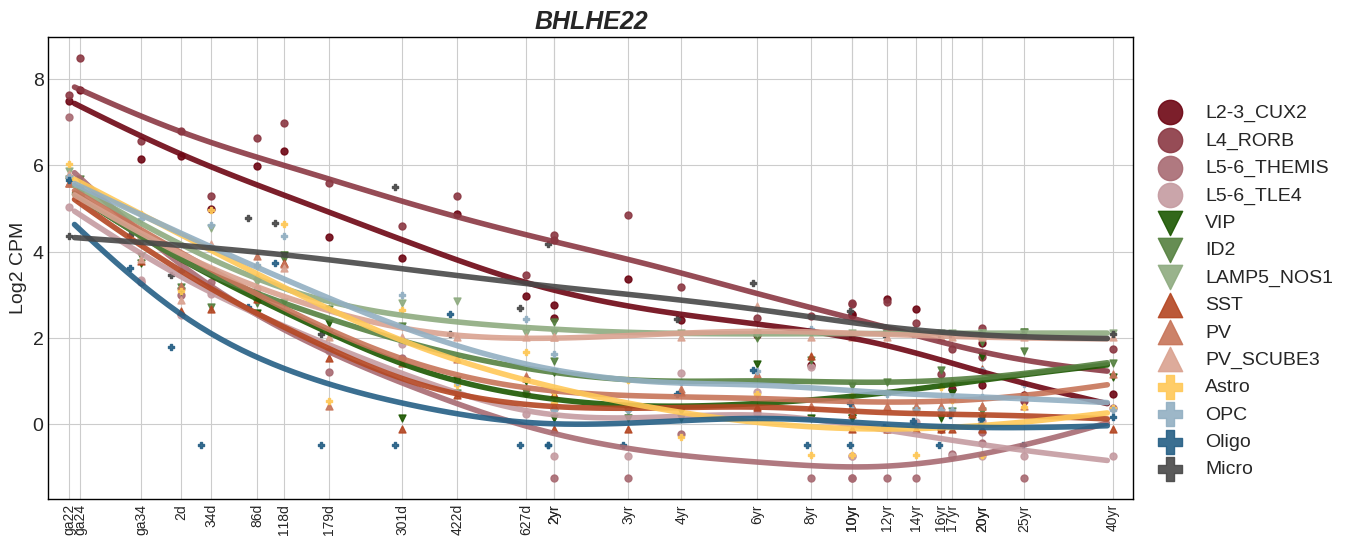

In [22]:
plot_cluters_gene( all_clusts, 'BHLHE22');

## **Rate of Change Analysis**

In [23]:
def plot_trend_changes( ref_keys, title, clust_order=adata.uns['major_clust_plot_order']):
    plt.figure( figsize=(12,4))
    for ref_key in clust_order[np.in1d( clust_order, ref_keys)]:
        arc_ages = logTMMs[ref_key].columns.values
        arc_x = np.linspace( min(arc_ages), max(arc_ages), n_grid_pts)
        year_x = np.sinh( arc_x)*adata.uns['arcsinh_cofactor']
        df = gam_fits[ref_key]
        min_max_scaler = preprocessing.MinMaxScaler()
        gene_norms = min_max_scaler.fit_transform( df.T).T
        norm_rates = np.diff( gene_norms, axis=1)/np.diff( year_x)
        diff_means = np.mean( np.abs(norm_rates), axis=0)
        xx = np.linspace( min(arc_ages), max(arc_ages), n_grid_pts-1)
        plt.plot( xx, diff_means, color=adata.uns['major_clust_colors_dict'][ref_key], linewidth=2.5, label=ref_key)
    # all ages are present in L2-3 traj
    xticks = logTMMs['L2-3_CUX2'].columns.values
    plt.xticks( ticks=xticks, labels=plot_labels['L2-3_CUX2'], rotation=90, fontsize=10);
    plt.title( title, fontsize=18, weight='bold');
    plt.legend( bbox_to_anchor=(1.12, 0.45), loc="center");
    plt.show()
    return

def plot_trend_changes_arcsinh( ref_keys, title, clust_order=adata.uns['major_clust_plot_order']):
    plt.figure( figsize=(12,4))
    for ref_key in clust_order[np.in1d( clust_order, ref_keys)]:
        arc_ages = logTMMs[ref_key].columns.values
        df = gam_fits[ref_key]
        min_max_scaler = preprocessing.MinMaxScaler()
        gene_norms = min_max_scaler.fit_transform( df.T).T
        norm_rates = np.diff( gene_norms, axis=1)
        diff_means = np.mean( np.abs(norm_rates), axis=0)
        xx = np.linspace( min(arc_ages), max(arc_ages), n_grid_pts-1)
        plt.plot( xx, diff_means, color=adata.uns['major_clust_colors_dict'][ref_key], linewidth=2.5, label=ref_key)
    # all ages are present in L2-3 traj
    xticks = logTMMs['L2-3_CUX2'].columns.values
    plt.xticks( ticks=xticks, labels=plot_labels['L2-3_CUX2'], rotation=90, fontsize=10);
    plt.title( title, fontsize=18, weight='bold');
    plt.legend( bbox_to_anchor=(1.12, 0.45), loc="center");
    plt.show()
    return

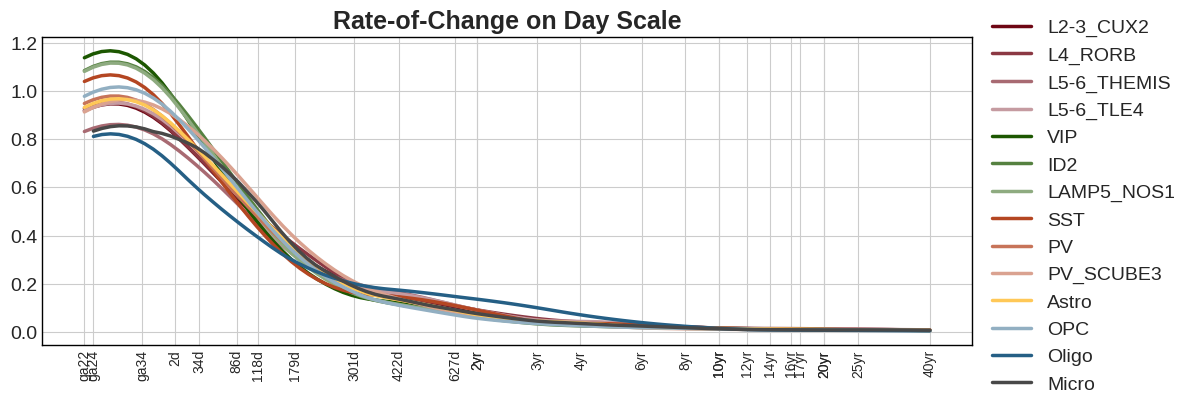

In [24]:
plot_trend_changes( list(gam_fits.keys()), 'Rate-of-Change on Day Scale');

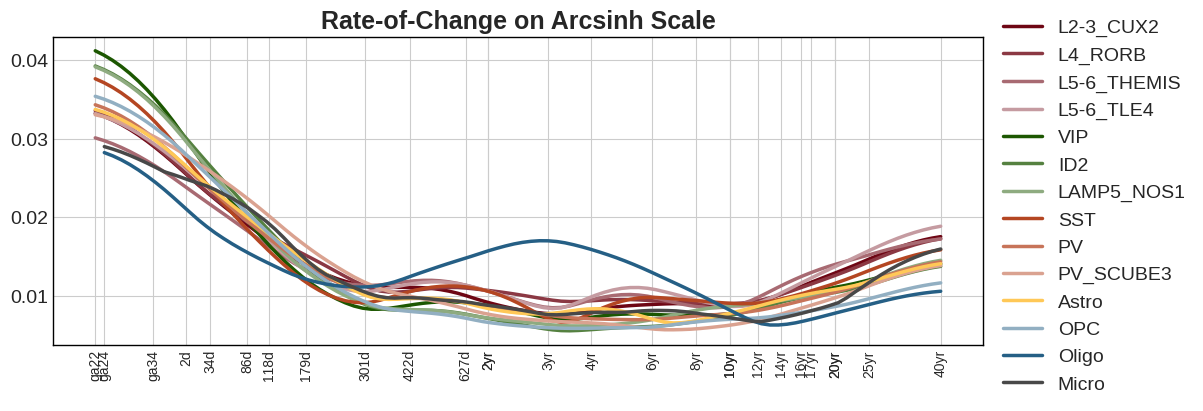

In [25]:
plot_trend_changes_arcsinh( list(gam_fits.keys()), 'Rate-of-Change on Arcsinh Scale');

In [26]:
def plot_trend_acc( ref_keys, title, clust_order=adata.uns['major_clust_plot_order']):
    plt.figure( figsize=(12,4))
    for ref_key in clust_order[np.in1d( clust_order, ref_keys)]:
        arc_ages = logTMMs[ref_key].columns.values
        arc_x = np.linspace( min(arc_ages), max(arc_ages), n_grid_pts)
        year_x = np.sinh( arc_x)*adata.uns['arcsinh_cofactor']
        df = gam_fits[ref_key]
        min_max_scaler = preprocessing.MinMaxScaler()
        gene_norms = min_max_scaler.fit_transform( df.T).T
        norm_rates = np.diff( gene_norms, axis=1)/np.diff( year_x)
        norm_rates2 = np.diff( norm_rates)/np.diff( year_x[:-1])
        diff_means = np.mean( np.abs(norm_rates2), axis=0)
        xx = np.linspace( min(arc_ages), max(arc_ages), n_grid_pts-2)
        plt.plot( xx, diff_means, color=adata.uns['major_clust_colors_dict'][ref_key], linewidth=2.5, label=ref_key)
    # all ages are present in L2-3 traj
    xticks = logTMMs['L2-3_CUX2'].columns.values
    plt.xticks( ticks=xticks, labels=plot_labels['L2-3_CUX2'], rotation=90, fontsize=10);
    plt.title( title, fontsize=18, weight='bold');
    plt.legend( bbox_to_anchor=(1.12, 0.45), loc="center");
    plt.show()
    return

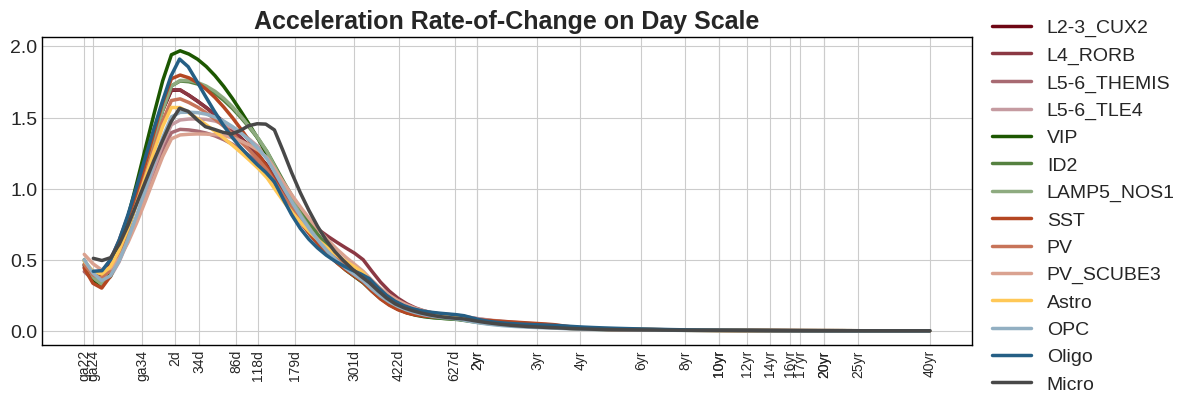

In [27]:
plot_trend_acc(  list(gam_fits.keys()), 'Acceleration Rate-of-Change on Day Scale');

There are only 58 devDEGs in the microglia trajectory.